<a href="https://colab.research.google.com/github/krogenth/IsBird/blob/main/CSC574_Is_Bird.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# grab GPU information
# this specific model has 16GB, so if we are given all of this VRAM, we can store our entire dataset
# to rerun, change: Runtime -> Change runtime type -> GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5b881b2a-0c59-e896-e7f7-478f5e5c55da)


In order to reference files, please read: https://stackoverflow.com/questions/50893250/how-to-reference-shared-files-and-folders-in-google-colab

In [ ]:
!cat /proc/meminfo

MemTotal:       13333568 kB
MemFree:        10876712 kB
MemAvailable:   12535960 kB
Buffers:           77924 kB
Cached:          1730848 kB
SwapCached:            0 kB
Active:           922744 kB
Inactive:        1269960 kB
Active(anon):     358132 kB
Inactive(anon):      352 kB
Active(file):     564612 kB
Inactive(file):  1269608 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               408 kB
Writeback:             0 kB
AnonPages:        383900 kB
Mapped:           214372 kB
Shmem:               984 kB
Slab:             174172 kB
SReclaimable:     131624 kB
SUnreclaim:        42548 kB
KernelStack:        3888 kB
PageTables:         5332 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666784 kB
Committed_AS:    2871348 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:             1024 kB
AnonHugePages:   

In [ ]:
# Preliminaries
from __future__ import print_function

import keras
import keras.utils as np_util
from keras.preprocessing import image   # needed for image processing
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

import numpy as np
import matplotlib.pyplot as plt

import os   # used to go through directories to get files
from google.colab import drive
import cv2
import random

%matplotlib inline

In [ ]:
# mount google drive so we can access bird images
# requires authentication to mount
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# define arrays to store data
x_train = []
y_train = []

# define arrays to store results
x_test = []
y_test = []

# dictionary to store categories of birds
categories = {}

In [ ]:
# set the training data directory, read in files
# all files are .jpg, so that is all we need to look for

# after trying, the amount of data stored from this is indeed too much, and crashes the notebook
# therefore, we would need to either use our PCs, and/or trim the data
# by rough calculations, we should be able to support roughly 20000 images, at most, within RAM(not VRAM)

train_directory = "drive/MyDrive/birds/train"

# to count what image we are on
i = 0
max_images = 9000

# to count what category we are on
category_count = 0;

for dirName, subDirs, fileList in os.walk(train_directory):
  for entry in fileList:
    if (".jpg" in entry):
      category = dirName[dirName.rfind("/") + 1 : len(dirName)]
      if not (category in categories):
        categories[category] = category_count
        category_count = category_count + 1
      x_train.append(cv2.imread(dirName + "/" + entry))
      y_train.append(categories[category])
      i = i + 1
      if (i == max_images):
        break
  if (i == max_images):
    break

In [ ]:
# set the testing data directory, read in files
test_directory = "drive/MyDrive/birds/test"

for dirName, subDirs, fileList in os.walk(test_directory):
  for entry in fileList:
    if(".jpg" in entry):
      category = dirName[dirName.rfind("/") + 1 : len(dirName)]
      if (category in categories):
        x_test.append(cv2.imread(dirName + "/" + entry))
        y_test.append(categories[category])

In [ ]:
# grab arrays as numpy arrays, and convert to integers to output image cleanly first
x_train = np.array(x_train).astype("float32")
x_test = np.array(x_test).astype("float32")

x_train /= 255
x_test /= 255

In [ ]:
# verify categories
print(category_count)
print(categories)

66
{'AMERICAN AVOCET': 0, 'AMERICAN BITTERN': 1, 'ALEXANDRINE PARAKEET': 2, 'AFRICAN FIREFINCH': 3, 'AMERICAN KESTREL': 4, 'ALBATROSS': 5, 'AMERICAN COOT': 6, 'AMERICAN GOLDFINCH': 7, 'AFRICAN CROWNED CRANE': 8, 'AMERICAN PIPIT': 9, 'BALI STARLING': 10, 'BANANAQUIT': 11, 'ARARIPE MANAKIN': 12, 'ANTBIRD': 13, 'BALD EAGLE': 14, 'AMERICAN REDSTART': 15, 'BALTIMORE ORIOLE': 16, 'ANNAS HUMMINGBIRD': 17, 'ANHINGA': 18, 'ASIAN CRESTED IBIS': 19, 'BELTED KINGFISHER': 20, 'BAY-BREASTED WARBLER': 21, 'BAR-TAILED GODWIT': 22, 'BANDED BROADBILL': 23, 'BARN OWL': 24, 'BIRD OF PARADISE': 25, 'BARN SWALLOW': 26, 'BLACK FRANCOLIN': 27, 'BEARDED BARBET': 28, 'BARRED PUFFBIRD': 29, 'BLACKBURNIAM WARBLER': 30, 'BLACK VULTURE': 31, 'BLACK-CAPPED CHICKADEE': 32, 'BLACK SWAN': 33, 'BLACK-NECKED GREBE': 34, 'BLACK SKIMMER': 35, 'BLACK-THROATED SPARROW': 36, 'BLUE HERON': 37, 'BLUE GROUSE': 38, 'BLACK THROATED WARBLER': 39, 'CALIFORNIA CONDOR': 40, 'BROWN NOODY': 41, 'CAPUCHINBIRD': 42, 'CALIFORNIA GULL': 43,

In [ ]:
# this needs to be after changing the arrays to numpy arrays, because .shape is a part of the numpy.array object
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

print(y_train, 'train results')
print(y_test, 'test results')
print(y_test[0])

(9000, 224, 224, 3) train samples
(339, 224, 224, 3) test samples
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

(224, 224, 3)
[[[0.6039216  0.5686275  0.53333336]
  [0.6039216  0.5686275  0.53333336]
  [0.60784316 0.57254905 0.5372549 ]
  ...
  [0.654902   0.60784316 0.5686275 ]
  [0.6627451  0.6039216  0.5686275 ]
  [0.6627451  0.6039216  0.5686275 ]]

 [[0.60784316 0.57254905 0.5372549 ]
  [0.60784316 0.57254905 0.5372549 ]
  [0.6117647  0.5764706  0.5411765 ]
  ...
  [0.654902   0.60784316 0.5686275 ]
  [0.6666667  0.60784316 0.57254905]
  [0.6627451  0.6039216  0.5686275 ]]

 [[0.6        0.5647059  0.5294118 ]
  [0.6        0.5647059  0.5294118 ]
  [0.6039216  0.5686275  0.53333336]
  ...
  [0.6509804  0.6039216  0.5647059 ]
  [0.65882355 0.6        0.5647059 ]
  [0.65882355 0.6        0.5647059 ]]

 ...

 [[0.3137255  0.37254903 0.40784314]
  [0.30588236 0.37254903 0.40784314]
  [0.32156864 0.38039216 0.41568628]
  ...
  [0.23921569 0.36862746 0.43137255]
  [0.24313726 0.37254903 0.43529412]
  [0.24705882 0.3764706  0.4392157 ]]

 [[0.30980393 0.37254903 0.41960785]
  [0.30588236 0.3764706

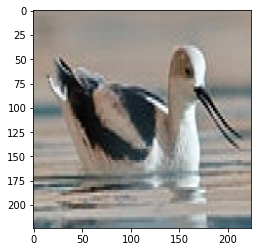

In [ ]:
# verify the images are 224 x 224
print(x_train[0].shape)

# make sure it looks like numbers are in there
print(x_train[0])

# verify image looks like a bird
plt.imshow(x_train[0])

In [ ]:
# arrays are sequential, we want them random, so let's make them random!
def shuffle(a, b, seed):
   rand_state = np.random.RandomState(seed)
   rand_state.shuffle(a)
   rand_state.seed(seed)
   rand_state.shuffle(b)

seed = random.randint(1, 10000000)
shuffle(x_train, y_train, seed)
shuffle(x_test, y_test, seed)

test1 = [1, 2, 3, 4, 5]
test2 = ['a', 'b', 'c', 'd', 'e']
shuffle(test1, test2, seed)
print(test1)
print(test2)

[5, 3, 1, 4, 2]
['e', 'c', 'a', 'd', 'b']


11


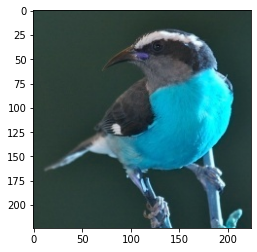

In [ ]:
# verify arrays are now random
print(y_test[0])
plt.imshow(x_test[0])

In [ ]:
y_train = np_util.to_categorical(y_train, category_count)
y_test = np_util.to_categorical(y_test, category_count)

In [ ]:
# reshape the input data
x_train = x_train.reshape(len(x_train), 224*224*3)
x_test = x_test.reshape(len(x_test), 224*224*3)

In [ ]:
x_test.shape[1:]

(224, 224, 3)

In [ ]:
# create the model
model = Sequential()
model.add(Dense(200, activation='relu', input_dim=x_test.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(category_count, activation='softmax'))

In [ ]:
# A CNN version, very slow, requires images to stay in original shape

model = Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Dropout(0.2))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(keras.layers.Flatten())
model.add(Dense(category_count, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 200)               30105800  
_________________________________________________________________
dropout_25 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 200)             

In [ ]:
# compile model first
learning_rate = 0.1
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True), metrics=['accuracy'])

In [ ]:
batch_size = 128
epochs = 20
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/20
71/71 [==============================] - 28s 390ms/step - loss: 0.2174 - accuracy: 0.0164 - val_loss: 0.0910 - val_accuracy: 0.0147
Epoch 2/20
71/71 [==============================] - 27s 384ms/step - loss: 0.0896 - accuracy: 0.0196 - val_loss: 0.0884 - val_accuracy: 0.0295
Epoch 3/20
71/71 [==============================] - 27s 386ms/step - loss: 0.0881 - accuracy: 0.0244 - val_loss: 0.0842 - val_accuracy: 0.0295
Epoch 4/20
71/71 [==============================] - 27s 387ms/step - loss: 0.0866 - accuracy: 0.0189 - val_loss: 0.0874 - val_accuracy: 0.0501
Epoch 5/20
71/71 [==============================] - 27s 386ms/step - loss: 0.0856 - accuracy: 0.0308 - val_loss: 0.0853 - val_accuracy: 0.0354
Epoch 6/20
71/71 [==============================] - 27s 385ms/step - loss: 0.0843 - accuracy: 0.0303 - val_loss: 0.0792 - val_accuracy: 0.0619
Epoch 7/20
71/71 [==============================] - 27s 384ms/step - loss: 0.0833 - accuracy: 0.0390 - val_loss: 0.0819 - val_accuracy: 0.0649

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.06254842877388
Test accuracy: 0.20943953096866608


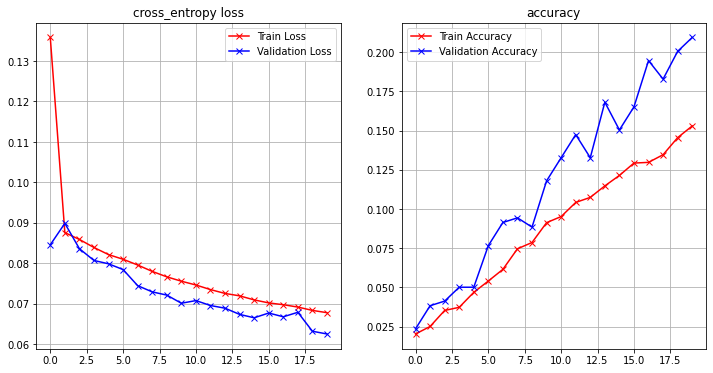

In [ ]:
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)
    
plot_loss_accuracy(history)